# Data-driven experimentation via UpTrain Evaluations
Welcome to this comprehensive guide on evaluating LLM applications and experimenting with different retrieval configurations with UpTrain. This guide aims to provide a seamless experience, offering step-by-step instructions, code explanations, and best practices.

## Overview
UpTrain is an open-source LLM evaluation tool. It provides pre-built metrics to check LLM responses on aspects such as correctness, hallucination, toxicity, etc. as well as provides an easy-to-use framework to configure custom checks.

## What You'll Learn
- Setting up your environment with the necessary packages and credentials.
- Creating a simple RAG-based application using VectorDB, OpenAI, and Langchain.
- Leveraging the power of UpTrain to evaluate the quality of our application.
- Experimenting with different chunking strategies and quantifying the results.
- Utilizing UpTrain's framework for data-driven experimentation and refinement.

## Prerequisites
- Basic knowledge of Python programming.
- An UpTrain account.

Let's dive in and start building!



**Setting up the environment**: Before we begin, it's essential to ensure all the necessary packages are installed. Run the cell below to install the required libraries for our project. This will install uptrain, openai, langchain, and faiss.

In [1]:
!pip install uptrain
!pip install openai
!pip install langchain
!pip install faiss

  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Successfully uninstalled h11-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
uptrain-server 0.1 requires fsspec>=2023.6.0, but you have fsspec 2023.5.0 which is incompatible.


**Authentication**: The next step involves setting the required environment variables - mainly the openai key (for generating responses), and uptrain api key (for evaluating responses). You can create an account with UpTrain and generate the api key for free. Please visit https://uptrain.ai/

In [2]:
import os
os.environ["OPENAI_API_KEY"] = "sk-*****************"
UPTRAIN_API_KEY = "up-******************"

**Importing Necessary Modules**: With the initial setup complete, let's import the essential classes and modules we'll use throughout this project. The following cell imports the required classes from langchain and Faiss.

In [3]:
import openai

from uptrain import APIClient, Evals

from langchain.vectorstores import VectorStore
from langchain.embeddings import OpenAIEmbeddings

**Loading Data from the Web**: Our application requires data to process and generate insights. In this step, we'll fetch content from a URL using the WebBaseLoader class. The loaded data will be stored in the data variable. You can replace the URL with any other source if needed.


In [4]:
from langchain.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://cloud.google.com/vertex-ai/docs/generative-ai/learn/generative-ai-studio")
data = loader.load()

**Splitting the Data**: To process the data more efficiently, we'll split the loaded content into smaller chunks. The RecursiveCharacterTextSplitter class helps in achieving this by dividing the data based on specified character limits.

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 200, chunk_overlap = 0)
all_splits = text_splitter.split_documents(data)

**Setting Up VectorDB with OpenAI Embeddings**: For efficient storage and retrieval of our data, we use Faiss in conjunction with OpenAI embeddings. The following cell sets up the necessary environment variables and initializes the Faiss vectorDB instance with OpenAI embeddings.

In [6]:
from langchain.vectorstores.faiss import FAISS
from langchain.embeddings import OpenAIEmbeddings

vectorstore = FAISS.from_documents(documents=all_splits, embedding= OpenAIEmbeddings())

**Setting Up the QA Prompt**: Once our data is processed and stored, we can use it to answer queries. The following cell defines a "generate_llm_response" which finds the document closest to the given question via vector similarity search and uses OpenAI's GPT-3.5-Turbo to generate the response.

In [7]:
def generate_llm_response(question, vectorstore):
    documents = vectorstore.similarity_search(question, k= 1)
    context = " , ".join([x.page_content for x in documents])

    prompt = f"""
        Answer the following user query using the retrieved document in less than 3 sentences:
        {question}
        The retrieved document has the following text:
        {context}

        Answer:
    """

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo", messages=[{"role": "system", "content": prompt}], temperature=0.1
    ).choices[0]["message"]["content"]
    
    return [{'question': question, 'context': context, 'response': response}]

**Let's try it out**: Let's try asking our QnA bot about Vertex AI.

In [8]:
generate_llm_response('What is Vertex AI?', vectorstore)

[{'question': 'What is Vertex AI?',
  'context': 'Generative AI on Vertex AI\n                    \n\n                      Build, tune, and deploy foundation models on Vertex AI.',
  'response': 'Vertex AI is a platform that allows users to build, tune, and deploy foundation models for generative AI.'}]

**Let's define more questions**: We now define a set of questions to test our bot upon and evaluate the quality of responses.

In [9]:
questions = [
    "What is the primary purpose of Generative AI Studio?",
    'What is Responsible AI?',
    'What is Prompt Designing?',
    'What is Vertex AI?',
    "What are some of the tasks you can perform in Generative AI Studio?",
    'Which method is good, Prompt Designing or fine-tuning a model?',
    'How to get good quality responses from llm?',
    'What are some of the foundation models offered by Vertex AI?',
    "How can you ensure that a designed prompt elicits the desired response from a language model?",
    'How to use Generative AI studio to convert text to speech.',
    "Where can you find sample prompts to test models in Generative AI Studio?"
    'How can I customize the foundation models offered by vertex AI?',
    "What are some code examples from vertex ai?"
]

results = []
for question in questions:
    results.extend(generate_llm_response(question, vectorstore))

**Running Experiments using UpTrain**: Let's also see how UpTrain can be used to conduct data-driven experimentation. We will increase the chunk_size from 200 to 1000 and see how that impacts the context retrieval quality.

**Generate new embeddings**: We will again use faiss vectorDB to store new document embeddings

In [10]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 0)
all_splits = text_splitter.split_documents(data)
vectorstore_new = FAISS.from_documents(documents=all_splits, embedding= OpenAIEmbeddings())

**Generate responses with new vectorstore**: Let's generate new responses for the same set of questions. 

In [11]:
results_larger_chunk = []
for question in questions:
    results_larger_chunk.extend(generate_llm_response(question, vectorstore_new))

**Append chunk size information**: Let's add the corresponding chunk size information for both sets of results. We will pass this column name to UpTrain to compare the two experiments

In [12]:
_ = [x.update({"chunk_size": 200}) for x in results]
_ = [x.update({"chunk_size": 1000}) for x in results_larger_chunk]

**Evaluating Experiments using UpTrain**: UpTrain's APIClient also provides a "evaluate_experiments" method which takes the input data to be evaluated along with the list of checks to be run and the name of the columns associated with the experiment.

In [13]:
from uptrain import APIClient
eval_client = APIClient(uptrain_api_key = UPTRAIN_API_KEY)

_ = eval_client.evaluate_experiments(
    project_name="VertexAI-QnA-Bot-Chunk-Size-Experiments",
    data=results + results_larger_chunk,
    checks=[Evals.CONTEXT_RELEVANCE, Evals.RESPONSE_RELEVANCE, Evals.FACTUAL_ACCURACY],
    exp_columns=['chunk_size']
)

2023-11-15 16:36:42.262 | INFO     | uptrain.framework.remote:log_and_evaluate:455 - Sending evaluation request for rows 0 to <50 to the Uptrain server


**Access UpTrain Dashboards**: We can access the evaluation results at https://demo.uptrain.ai/dashboard/ - the same API key can be used to access the dashboards. 

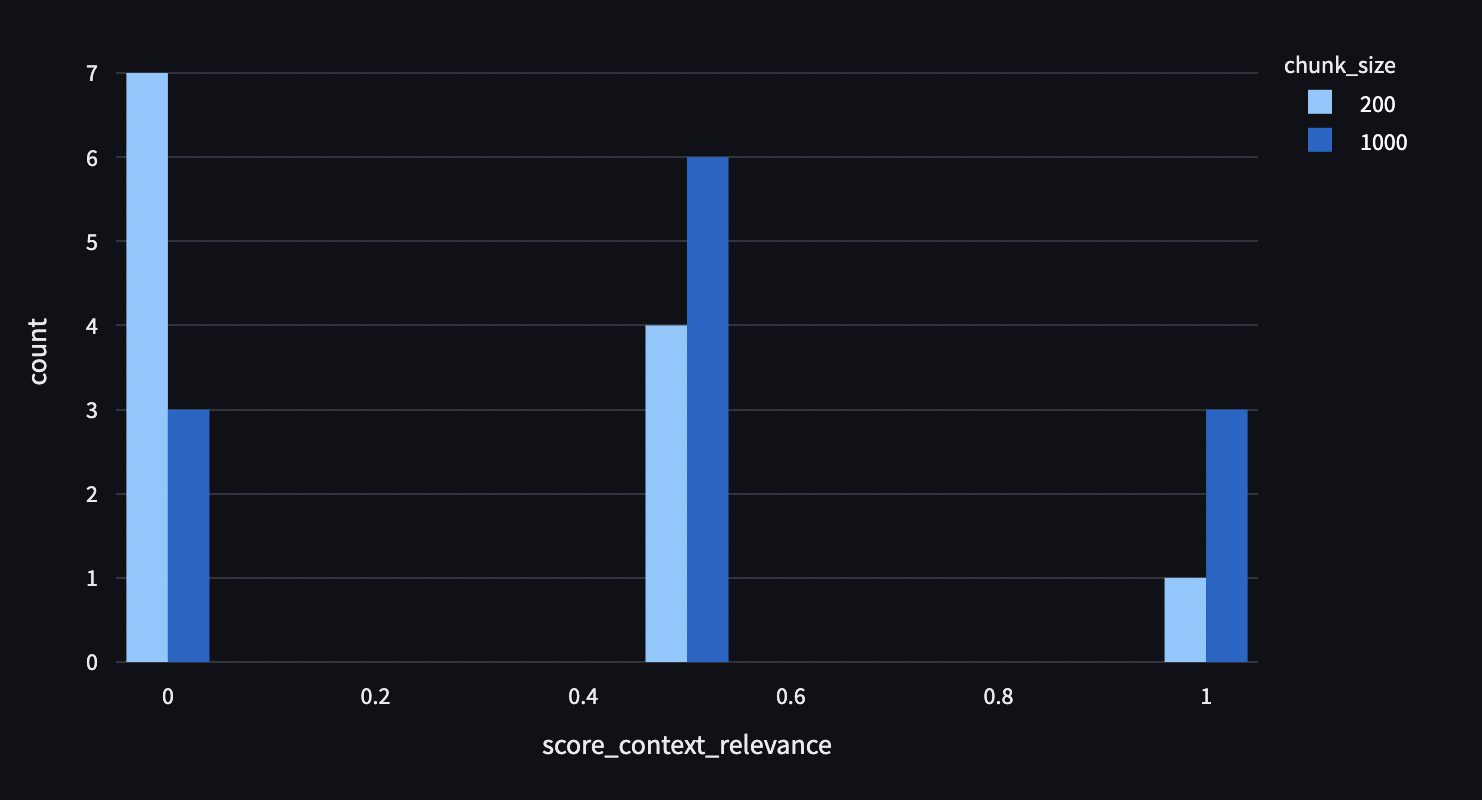